In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import scipy.special as special
from scipy.integrate import quad
from scipy.integrate import nquad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
#pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'    

In [8]:
C_pi = 3.1415926535897932384
BESSEL_EPSILON_ORDER = 16 

SLOPE1 = (-6.627757624078600696e-01)
SLOPE2 = (-6.656260931106707801e-01)
SLOPE3 = (-6.543033585865805080e-01)
INTERCEPT1 = (1.063380408975875602e+00)
INTERCEPT2 = (2.563324856985127465e-01)
INTERCEPT3 = (2.720161927383055733e-01)
N_JN = 30.
DBL_MIN = 2.2250738585072014e-308
#DBL_MIN = 0.05


def BesselJ_Debye_Eps_Exp(n, x):
    first_time = 1
    At = [None] * 16
    
    def set_At( At ):
        m = 0
        M = 0.
        for m in range(0, BESSEL_EPSILON_ORDER):
            M = (m + 1)/3.
            At[m] = np.sin(C_pi * M) * 6.**M * np.exp(special.gammaln(M))
        return 0.

    #set_At(At)
    
    if(first_time == 1):
        set_At(At)
        first_time = 0
    
    if(x > 1.e55):
        return 0.
    
    ez = x - n
    z = x**(1./3.)
    
    t3 = z * z
    t4 =  x * z     
    t10 = t4 *  t4
    t38 = 810485676000000 * At[4] * t3
    t44 = x
    t70 = At[7] * t3
    t93 = At[10] * t3
    t107 = At[13] * t3
    t114 =  ez * ez
    t146 = t10 * t10
    t149 = ((-5403237840000 * At[6] + (69470200800000 * At[4] + 19451656224000000 * At[0] * t4) * t3) * t10 * z + (-401283384 * At[15] + (4707059994 * At[13] + (3012121710 * At[12] + (-36011689560 * At[10] + (8027667648000 * At[9] + (-8027667648000 * At[7] + (-1296777081600000 * At[3] + 19451656224000000 * At[1] * t3) * t4) * t3) * z) * t3) * z) * t3 + ((-41423013450 * At[12] + (484040056500 * At[10] + (67540473000000 * At[6] - t38) * t4) * t3) * t44 + (1748257220 * At[15] + (-19964735910 * At[13] + (-2594411820000 * At[9] + (29331862560000 * At[7] + 3241942704000000 * At[3] * t4) * t3) * t4) * t3 + ((78248884350 * At[12] + (-860873013000 * At[10] + (-94556662200000 * At[6] + t38) * t4) * t3) * t44 + (-1938419560 * At[15] + (20997160275 * At[13] + (2283511230000 * At[9] - 21612951360000 * t70) * t4) * t3 + ((-47153256150 * At[12] + (459918459000 * At[10] + 27016189200000 * At[6] * t4) * t3) * t44 + (849093050 * At[15] + (-8397889500 * At[13] + (-643242600000 * At[9] + 3859455600000 * t70) * t4) * t3 + ((11448186750 * At[12] - 88445857500 * t93) * t44 + (-173573400 * At[15] + (1474097625 * At[13] + 53603550000 * At[9] * t4) * t3 + ((-1161410250 * At[12] + 5360355000 * t93) * t44 + (-113704500 * t107 + 17481100 * At[15] + (40608750 * At[12] * t44 + (-833000 * At[15] + 3123750 * t107 + 14875 * At[15] * t114) * ez) * ez) * ez) * ez) * ez) * ez) * ez) * ez) * ez) * ez) * ez) * ez) * ez) / ( C_pi * t146 * 0.58354968672000000e17 )
    return t149
    
def BesselJ_Meissel_First(n, x):
    fn =  n  
    z = x/fn
    eps = (fn-x)/fn
    Z = np.sqrt(eps*(1+z))
    ninv = 1./fn
    U = 1./(n*Z*Z*Z)
    t1 = z * z
    t2 =  ninv * ninv
    
    Vsum1  = (U * (860160 + 1290240 * t1 + ((-2580480 - 645120 * t1) * t1 + (-28672 + (2709504 + (6547968 + 672000 * t1) * t1) * t1 + ((-2580480 + (-23224320 + (-18708480 - 1048320 * t1) * t1) * t1) * t1 + (-8192 + (-2519040 + (-60518400 + (-151828480 + (-61254720 - 2163168 * t1) * t1) * t1) * t1) * t1 + ((2580480 + (138700800 + (800163840 + (940423680 + (228049920 + 5537280 * t1) * t1) * t1) * t1) * t1) * t1 + (6144 + (-2644992 + (-299351808 + (-3405435264 + (-8653594320 + (-5897669400 + (-954875250 - 16907985 * t1) * t1) * t1) * t1) * t1) * t1) * t1 + (2580480 + (625766400 + (12841758720 + (60631119360 + (86387857920 + (38435160960 + (4450158720 + 59968440 * t1) * t1) * t1) * t1) * t1) * t1) * t1) * t1 * U) * U) * U) * U) * U) * U) * U)) / 0.10321920e8
    
    Vsum2 = -(ninv * (420 + (-14 + (-4 + 3 * t2) * t2) * t2)) / 0.5040e4
    
    factor  = 1./( (fn+1.) * np.sqrt(Z) )
    
    if(Z < 1.e-3):
        invZp1 = 1 + (-1 + (1 + (-1 + (1 + (-1 + (1 - Z) * Z) * Z) * Z) * Z) * Z) * Z
    else:
        invZp1 = 1./(1.+Z)
    
    if((eps < 1.e-4) and (fn > 1.e3)):
        t3 = t2*t2
        loggamma_exp =  (ninv * (-420 + 14 * t2 - 4 * t3 + 3 * t3 * t2)) / 0.5040e4
        exp2 = -fn * np.sqrt(2.*eps) * eps * (0.984023040e9 + (0.442810368e9 + (0.303114240e9 + (0.233192960e9 + (0.190139040e9 + (0.160692840e9 + 0.139204065e9 * eps) * eps) * eps) * eps) * eps) * eps) / 0.1476034560e10
        exp_val = 0.5*np.log(0.5*fn/C_pi) + loggamma_exp + exp2 - Vsum1 - Vsum2
    else:
        exp_val = n*(  np.log(x*invZp1) - (1 - Z) ) - Vsum1 - Vsum2 - special.gammaln(n)
    
    retval = exp_factor(factor, exp_val)
    
    return retval

def BesselJ_Meissel_Second(n, x):
    fn = n
    z = x/fn
    eps = (x-fn)/fn
    Z = np.sqrt(eps*(1+z))
    U = 1./(n*Z*Z*Z)
    t1 = z * z
    t2 = U * U
    
    exp_val = (t1 * t2 * (-3072 - 768 * t1 + (3072 + (27648 + (22272 + 1248 * t1) * t1) * t1 + (-3072 + (-165120 + (-952576 + (-1119552 + (-271488 - 6592 * t1) * t1) * t1) * t1) * t1 + (3072 + (744960 + (15287808 + (72179904 + (102842688 + (45756144 + (5297808 + 71391 * t1) * t1) * t1) * t1) * t1) * t1) * t1) * t2) * t2) * t2)) / 0.12288e5
    
    Qt = n * ( Z - np.arccos(fn/x) )
    
    Qsum = -(U * (860160 + 1290240 * t1 + (28672 + (-2709504 + (-6547968 - 672000 * t1) * t1) * t1 + (8192 + (2519040 + (60518400 + (151828480 + (61254720 + 2163168 * t1) * t1) * t1) * t1) * t1 + (-6144 + (2644992 + (299351808 + (3405435264 + (8653594320 + (5897669400 + (954875250 + 16907985 * t1) * t1) * t1) * t1) * t1) * t1) * t1) * t2) * t2) * t2)) / 0.10321920e8
    
    factor = np.sqrt( 2 / ( C_pi*n*Z ) ) * np.cos( Qsum + Qt - 0.25*C_pi )
    
    retval = exp_factor( factor, exp_val )
    
    return retval

def BesselJ_Asympt1(n, x):
    z = x/n
    factor = 1./np.sqrt(2*C_pi*(n+1))
    exp_val = n*( 1 + np.log(0.5*z) )
    return( exp_factor( factor, exp_val ) )

def BesselJ_bigx(n, x):
    return  np.sqrt(2./(C_pi*x)) * np.cos( x - 0.5*C_pi*( n + 0.5 ) ) 

def exp_factor(f_factor, f_exp):
    if(f_factor == 0.):
        return 0.
    
    fabs_exp = abs(f_exp)
    
    if(fabs_exp < 1.e-3):
        x = f_exp
        return (f_factor * ( 1. + ((40320.+(20160.+(6720.+(1680.+(336.+(56.+(8.+x)*x)*x)*x)*x)*x)*x)*x / 40320.) ))
    elif(fabs_exp > 690.):
        if(f_factor < 0.):
            sign_f = -1.
        else:
            sign_f = 1.
        log_f = np.log(abs(f_factor))
        if(log_f * f_exp < 0.):
            return (sign_f * np.exp(log_f + f_exp))
        else:
            return (f_factor * np.exp(f_exp))
    else:
        return (f_factor * np.exp(f_exp))

#using JNprime_EQ1, as in harmony
def my_Bessel_dJ(n, x, jn):
    jn = my_Bessel_J(n, x)
    jnp1 = my_Bessel_J((n+1.), x)
    if(x == 0.):
        if(n >= 2.):
            return 0.
        if(n == 0.):
            return -jnp1
        return (n * jn / (x + DBL_MIN) - jnp1)
    return (n*(jn)/x - jnp1)

def my_Bessel_J(n, x):
    if( n < N_JN ): 
        return special.jv(n,x)
    fn = n
    logn = np.log10(fn)
    
    if(x < fn):
        y = np.log10((fn - x)/fn)
        if(x != fn):
            if(y > (SLOPE2*logn+INTERCEPT2)):
                return BesselJ_Meissel_First( n , x )
        return BesselJ_Debye_Eps_Exp( n , x )
    
    else:
        y = np.log10((x - fn)/x)
        if((x!=fn) and (y > (SLOPE3*logn+INTERCEPT3))):
            return BesselJ_Meissel_Second( n , x )
        return BesselJ_Debye_Eps_Exp( n , x )








#want to plot the integrand in Eq. 60 of the paper
#with filled in values of I(...), delta(yn), 

#constants in natural units
#m = 1.
#c = 1.
theta_e = 10.
#nu_c = 1
#B = 10.
#e = 1


#constants in Gaussian cgs units (values from harmony)
m = 9.1093826e-28
c = 2.99792458e10
e = 4.80320680e-10
B = 30.0
n_e = 1.




#variables to be set (frequency, observer angle, width of delta function, electron number density, 
# sum index n)


theta = np.pi/3.
epsilon = 0.01
n_e = 1
nu_c = e * B / (2. * np.pi * m * c)
nu = 1 * nu_c
nu_s = (2./9.) * nu_c * theta_e**2 * np.sin(theta)
n_e_nt = 1.
#p_PL = 2.2
p_PL = 3.
gamma_50_min = 1.
gamma_50_max = 1000.
#gamma_50_max = 100.
C = 1.
n_dn = (nu / nu_c) * abs(np.sin(theta))
Index_cutoff = 0.001
kappa = 3.5
gamma_cutoff = 1000.

In [9]:
def K_s(n, gamma):
    beta = np.sqrt(1. - 1./gamma**2.)
    cos_xi = (gamma * nu - n * nu_c) / (gamma * nu * beta * np.cos(theta))
    M = (np.cos(theta) - beta * cos_xi)/np.sin(theta)
    N = beta * np.sqrt(1. - cos_xi**2)
    z = (nu * gamma * beta * np.sin(theta) * np.sqrt(1. - cos_xi**2))/nu_c
    K_xx = M**2 * (special.jv(n, z))**2
    K_yy = N**2 * (special.jvp(n, z, 1))**2
#    K_xx = M**2 * (my_Bessel_J(n, z)**2)
#    K_yy = N**2 * (my_Bessel_dJ(n, z, 1)**2)
    ans = K_xx + K_yy
    return ans

def kappa_body_with_cutoff_no_norm(gamma):
#    kappa_body = (1. + (np.sqrt(1. + m**2 * c**2 * (gamma**2 - 1.)) - 1.)/(kappa * theta_e))**(- kappa - 1.)
    kappa_body = (1. + (gamma - 1.)/(kappa * theta_e))**(- kappa - 1.)
    kappa_cutoff = np.exp(- gamma/gamma_cutoff)
    kappa_here = kappa_body * kappa_cutoff
    return kappa_here

def kappa_with_normalization_extra_term(gamma):
    kappa_prefactor = 4. * np.pi * m**3 * c**3 * gamma * np.sqrt(gamma**2 - 1.)
    kappa_here_1 = kappa_body_with_cutoff_no_norm(gamma) * kappa_prefactor
    return kappa_here_1

kappa_norm_value = quad(kappa_with_normalization_extra_term, 1, np.inf, epsabs = 0, epsrel = 1e-8)[0]
#print kappa_norm_value

def kappa_with_cutoff_with_norm(gamma):
    kappa_dist = (1./kappa_norm_value) * kappa_body_with_cutoff_no_norm(gamma)
    return kappa_dist

def I_in_eq62(gamma, n):
    
    beta = np.sqrt(1. - 1./gamma**2.)
    cos_xi = (gamma * nu - n * nu_c) / (gamma * nu * beta * np.cos(theta))
    
    prefactor_Jnu = 2. * np.pi * e**2 * nu**2 / c
    d_3_p = m**3 * c**3 * gamma**2 * beta * 2 * np.pi
    
    ans = prefactor_Jnu * kappa_with_cutoff_with_norm(gamma) * d_3_p * K_s(n, gamma)
    
    return ans

def gamma_up_limit(n):
    gamma_up_nume = (n * nu_c /nu) + np.absolute(np.cos(theta)) * np.sqrt((n * nu_c /nu)**2 - (np.sin(theta))**2)
    gamma_deno = (np.sin(theta))**2
    gamma_up = gamma_up_nume / gamma_deno
    return gamma_up

def gamma_dn_limit(n):
    gamma_dn_nume = (n * nu_c /nu) - np.absolute(np.cos(theta)) * np.sqrt((n * nu_c /nu)**2 - (np.sin(theta))**2)
    gamma_deno = (np.sin(theta))**2
    gamma_dn = gamma_dn_nume / gamma_deno
    return gamma_dn
    
def jnu_integrand_in_eq62(gamma, n):
    
    beta = np.sqrt(1. - 1./gamma**2.)
    cos_xi = (gamma * nu - n * nu_c) / (gamma * nu * beta * np.cos(theta))
    
    prefactor_62 = 1. / (nu * beta * np.absolute(np.cos(theta)))
    
    f = prefactor_62 * I_in_eq62(gamma, n)
    
    return f

def jnu_n_integral_62_one(n):
    
    def jnu_integrand_in_eq62_gamma(gamma):
        jnu_integrand_62 = jnu_integrand_in_eq62(gamma, n)
        return jnu_integrand_62
    
    ans_once = quad(jnu_integrand_in_eq62_gamma, gamma_dn_limit(n), gamma_up_limit(n), epsabs = 0, epsrel = 1e-8)[0]
    
    return ans_once

n_peak = 300

def jnu_62_integral_from_n_max_to_n_limit(n_max, n_dn):
    
    if(n_max < n_dn):
        n_max = n_dn
    
    ans = quad(jnu_n_integral_62_one, n_max, C * n_peak, epsabs = 0, epsrel = 1e-8)[0]
    
    return ans
    

def jnu_62_sum_to_n_max_integral_to_n_limit(n_max_sum):
    ans = 0
    for i in range(int(n_dn + 1.), int(1 + n_dn + n_max_sum)):
        ans = ans + jnu_n_integral_62_one(i)
#        print ans
        
    total = ans + jnu_62_integral_from_n_max_to_n_limit(n_max_sum, n_dn)
    return total
#print nu_s, nu_c
print kappa_with_normalization_extra_term(100)

1.51895464344e-45
5.50835910138e-48


In [10]:
n_max = 200
print jnu_62_sum_to_n_max_integral_to_n_limit(n_max)

6.53522963631e-23


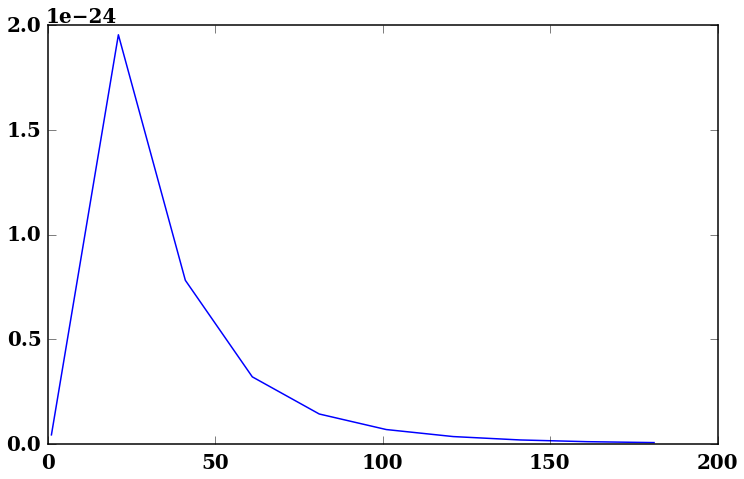

In [5]:
x_value = []
y_value = []

n_max_here = 200

step = int((int(n_max_here))/10.)


for i in xrange(int(n_dn + 1.), int(n_dn + 1. + n_max_here), step):
    x_value = x_value + [i]
    y_value = y_value + [jnu_n_integral_62_one(i)]

#    print int(n_dn + 1.), x_value
pl.plot(x_value, y_value)
#print x_value, int(n_dn+1) 
#pl.xlim([0,4000])

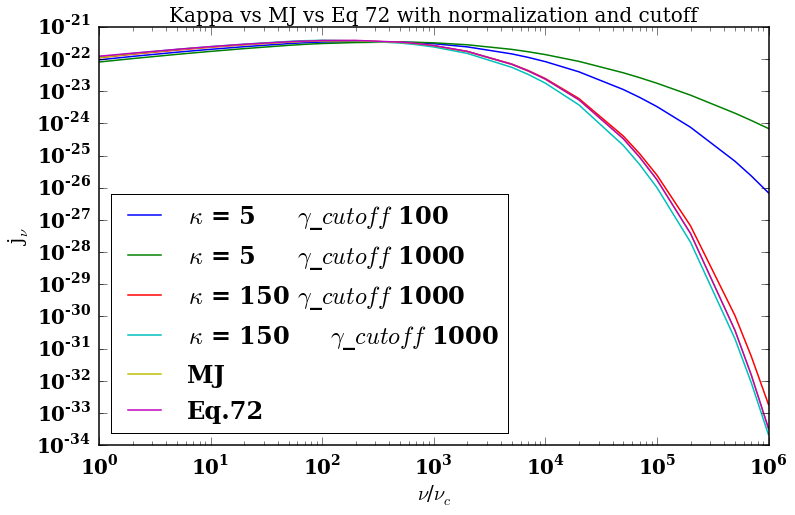

In [155]:
data1 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_150_with_cutoff1000_with_norm.txt')
data2 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/thermal_data_varing_nu.txt')
data3 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff1000_with_norm.txt')
data4 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff100_with_norm.txt')
data5 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_150_with_cutoff100_with_norm.txt')



def jnu_72(x):
    jnu_72_prefactor = n_e * np.sqrt(2) * np.pi * e**2 * nu_s / (3. * special.kn(2., 1./theta_e) * c)
    jnu_72_body = (np.sqrt(x/nu_s) + 2.**(11./12.) * (x/nu_s)**(1./6.))**2
    jnu_72_exp = np.exp(- (x/nu_s)**(1./3.))
    jnu_approximation_72 = jnu_72_prefactor * jnu_72_body * jnu_72_exp
    
    return jnu_approximation_72

#x = np.arange(1*nu_c, 1000000*nu_c, 10000)

jnu_72_outputs = jnu_72(nu_c * data1[:,0])

#print jnu_72_outputs

pl.xlabel("$\\nu$/$\\nu_c$")
pl.ylabel("j$_\\nu$")


pl.loglog(data4[:, 0], data4[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 100')
pl.loglog(data3[:, 0], data3[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 1000')
pl.loglog(data1[:, 0], data1[:, 1], label = '$\\kappa$ = 150 $\\gamma$_$cutoff$ 1000')
pl.loglog(data5[:, 0], data5[:, 1], label = '$\\kappa$ = 150     $\\gamma$_$cutoff$ 1000')
pl.loglog(data2[:, 0], data2[:, 1], label = 'MJ', color = 'y')
pl.loglog(data1[:,0], jnu_72_outputs, label = 'Eq.72')
pl.title("Kappa vs MJ vs Eq 72 with normalization and cutoff")

pl.legend(loc='lower left')
pl.show()

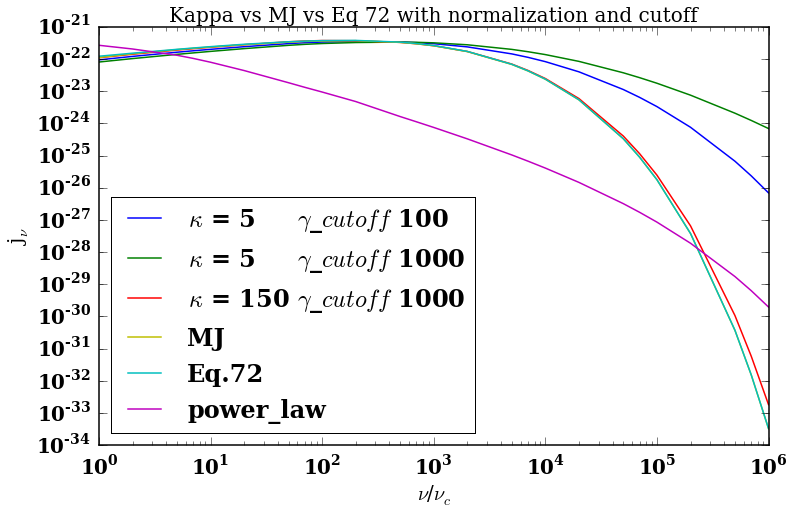

In [15]:
data1 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_150_with_cutoff1000_with_norm.txt')
data2 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/thermal_data_varing_nu.txt')
data3 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff1000_with_norm.txt')
data4 = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/kappa_5_with_cutoff100_with_norm.txt')
data_power_law = np.loadtxt('/Users/zhaoweizhang/Documents/summer_new/my_data_1/power_law_w_cutoff100_norm_B30.txt')



def jnu_72(x):
    jnu_72_prefactor = n_e * np.sqrt(2) * np.pi * e**2 * nu_s / (3. * special.kn(2., 1./theta_e) * c)
    jnu_72_body = (np.sqrt(x/nu_s) + 2.**(11./12.) * (x/nu_s)**(1./6.))**2
    jnu_72_exp = np.exp(- (x/nu_s)**(1./3.))
    jnu_approximation_72 = jnu_72_prefactor * jnu_72_body * jnu_72_exp
    
    return jnu_approximation_72

#x = np.arange(1*nu_c, 1000000*nu_c, 10000)

jnu_72_outputs = jnu_72(nu_c * data1[:,0])

#print jnu_72_outputs

pl.xlabel("$\\nu$/$\\nu_c$")
pl.ylabel("j$_\\nu$")

pl.loglog(data4[:, 0], data4[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 100')
pl.loglog(data3[:, 0], data3[:, 1], label = '$\\kappa$ = 5     $\\gamma$_$cutoff$ 1000')
pl.loglog(data1[:, 0], data1[:, 1], label = '$\\kappa$ = 150 $\\gamma$_$cutoff$ 1000')
pl.loglog(data2[:, 0], data2[:, 1], label = 'MJ', color = 'y')
pl.loglog(data1[:,0], jnu_72_outputs, label = 'Eq.72')
pl.loglog(data_power_law[:,0], data_power_law[:,1], label = 'power_law')


pl.title("Kappa vs MJ vs Eq 72 with normalization and cutoff")

pl.legend(loc='lower left')
pl.show()

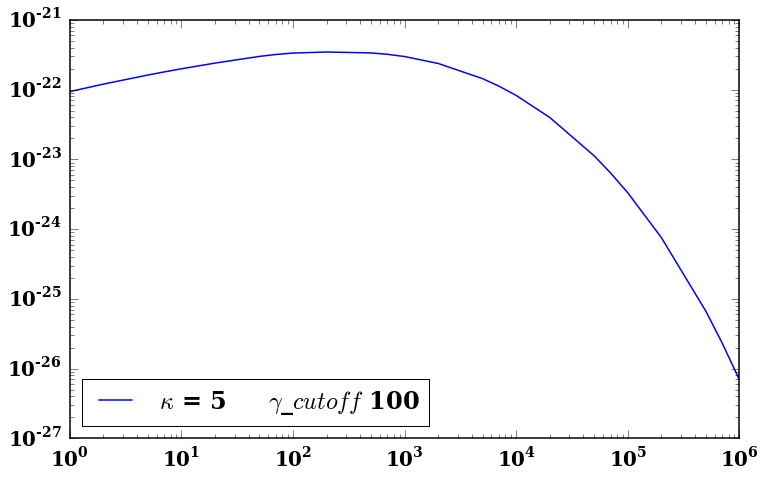

In [463]:
2e7

20000000.0

In [4]:
kappa_here = 150
theta_e_here = 10
def try_func(gamma):
    a = (1. + (gamma - 1.)/(kappa_here * theta_e_here))**(-kappa_here - 1.)
    return a

b = quad(try_func, 1, np.inf)
print b

(10.000000000000012, 1.181854264828044e-09)
